In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from datetime import datetime

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Load Mnist data

In [ ]:
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())

In [ ]:
batch_size = 256
# Download the dataset and create the dataloaders

generator1 = torch.Generator().manual_seed(42)
vali_set = torch.utils.data.random_split(mnist_train, [0.2, 0.8], generator=generator1)[0]
train_set = torch.utils.data.random_split(mnist_train, [0.2, 0.8], generator=generator1)[1]
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
vali_loader = DataLoader(vali_set, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# image_size =28
# Z_dim = 100
# X_dim = image_size*image_size
# # y_dim = train_labels.shape[1]
# h_dim = 128
# c = 0

# Hyperparameters
latent_dim = 100
lr = 1e-3
weight_decay = 1e-4
epochs = 11



In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity


In [ ]:
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

In [ ]:
def train_model(generator, discriminator, criterion, optimizer_G, optimizer_D, train_loader, num_epochs, device):
    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(train_loader):
            imgs = imgs.to(device)
            # Adversarial ground truths
            valid = torch.ones(imgs.size(0), 1, device=imgs.device)
            fake = torch.zeros(imgs.size(0), 1, device=imgs.device)

            # Configure input
            real_imgs = imgs.to(imgs.device)

            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()

            # Sample noise as generator input
            z = torch.randn(imgs.size(0), latent_dim, device=imgs.device)

            # Generate a batch of images
            gen_imgs = generator(z)

            # Loss measures generator's ability to fool the discriminator
            adversarial_loss = criterion
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        if epoch % 200 == 0:
            print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}]")
    return G_losses, D_losses



In [ ]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay)
criterion = torch.nn.BCELoss()
G_losses = []
D_losses = []
epochs = 20000
G_losses, D_losses = train_model(generator, discriminator, criterion, optimizer_G, optimizer_D, train_loader, epochs, device)

[Epoch 0/20000] [D loss: 0.078157] [G loss: 3.449200]


In [ ]:
torch.save(generator.state_dict(), 'generator_2k_01.pth')
torch.save(discriminator.state_dict(), 'discriminator_2k_01.pth')

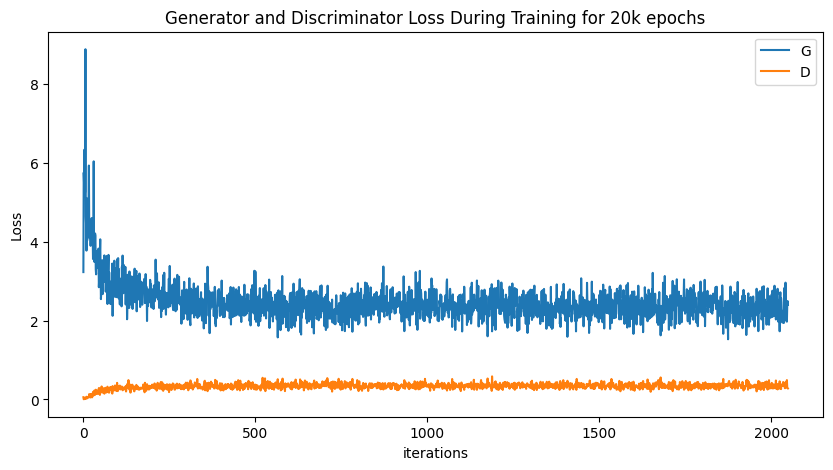

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training for 20k epochs")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

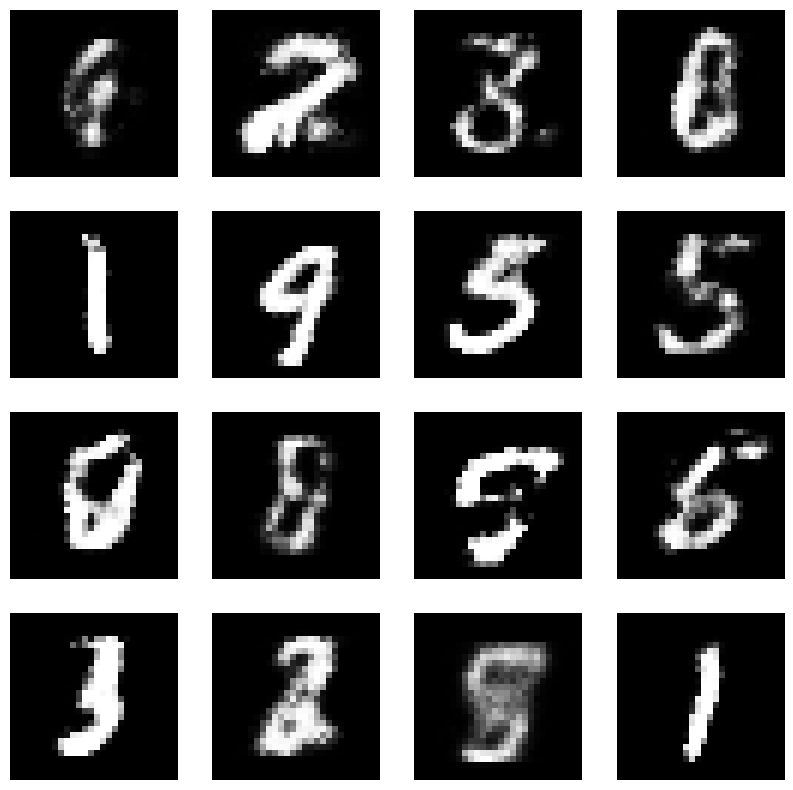

In [ ]:
# Generate images with the trained generator
z = torch.randn(16, latent_dim, device=device)
with torch.no_grad():
    gen_imgs = generator(z).cpu().view(-1, 28, 28)

# Plot these generated images
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(gen_imgs[i], cmap='gray')
    plt.axis('off')
plt.show()


In [ ]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay)
criterion = torch.nn.BCELoss()
G_losses = []
D_losses = []
# epochs = 100000
G_losses, D_losses = train_model(generator, discriminator, criterion, optimizer_G, optimizer_D, train_loader, epochs, device)

[Epoch 0/11] [D loss: 0.022520] [G loss: 6.276864]


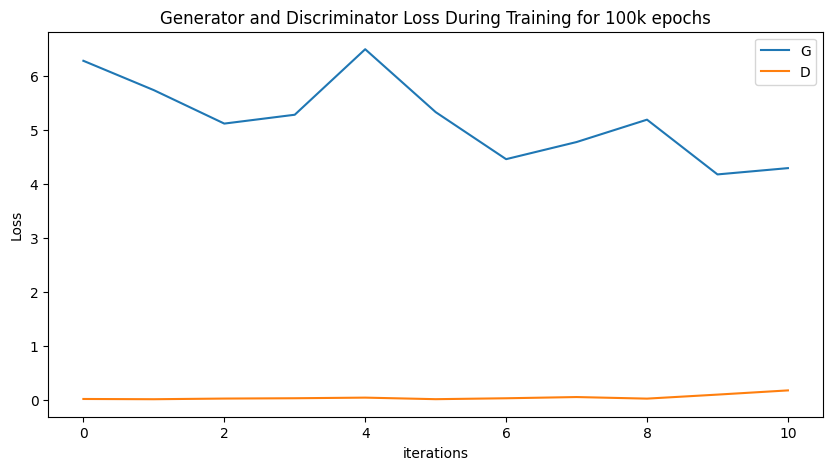

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training for 100k epochs")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

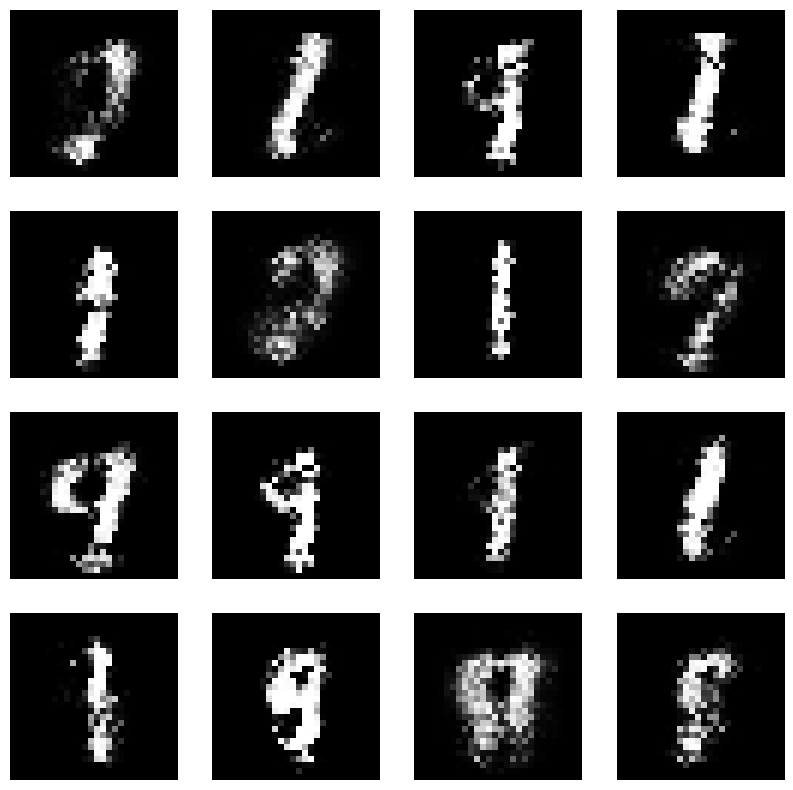

In [ ]:
# Generate images with the trained generator
z = torch.randn(16, latent_dim, device=device)
with torch.no_grad():
    gen_imgs = generator(z).cpu().view(-1, 28, 28)

# Plot these generated images
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(gen_imgs[i], cmap='gray')
    plt.axis('off')
plt.show()


# Task 2.2 Binary Cross-Entropy (BCE) Logits Loss

The BCE loss is ideal for models where you need to predict the probability of an input being in a class, commonly used in binary classification tasks such as spam detection, medical diagnostics, etc. Using BCEWithLogitsLoss is particularly beneficial as it handles numerical stability by combining the logistic sigmoid and the binary cross-entropy step into a single layer, which can prevent issues with the gradient when dealing with extreme values in logits.

In [ ]:
criterion = nn.BCEWithLogitsLoss()

NameError: name 'nn' is not defined

In [ ]:
# Optimizers
G_losses = []
D_losses = []
# epochs = 20000
G_losses, D_losses = train_model(generator, discriminator, criterion, optimizer_G, optimizer_D, train_loader, epochs, device)

[Epoch 0/11] [D loss: 0.505212] [G loss: 0.692397]


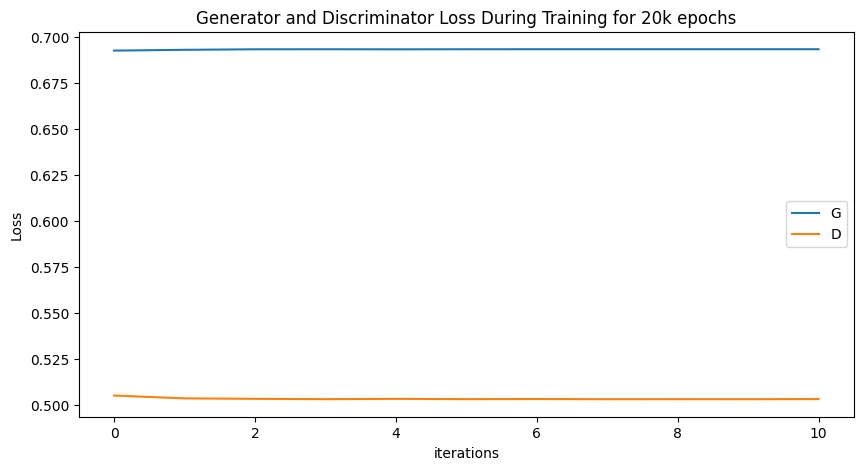

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training for 20k epochs")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

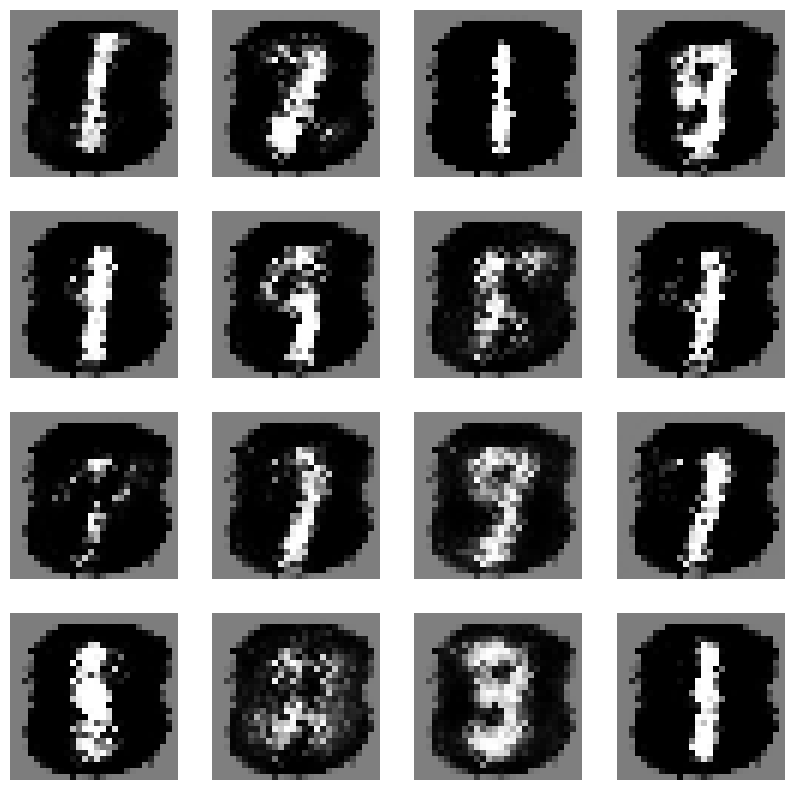

In [ ]:
# Generate images with the trained generator
z = torch.randn(16, latent_dim, device=device)
with torch.no_grad():
    gen_imgs = generator(z).cpu().view(-1, 28, 28)

# Plot these generated images
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(gen_imgs[i], cmap='gray')
    plt.axis('off')
plt.show()


In [ ]:
# Optimizers
G_losses = []
D_losses = []
# epochs = 100000
G_losses, D_losses = train_model(generator, discriminator, criterion, optimizer_G, optimizer_D, train_loader, epochs, device)

[Epoch 0/11] [D loss: 0.503268] [G loss: 0.693144]


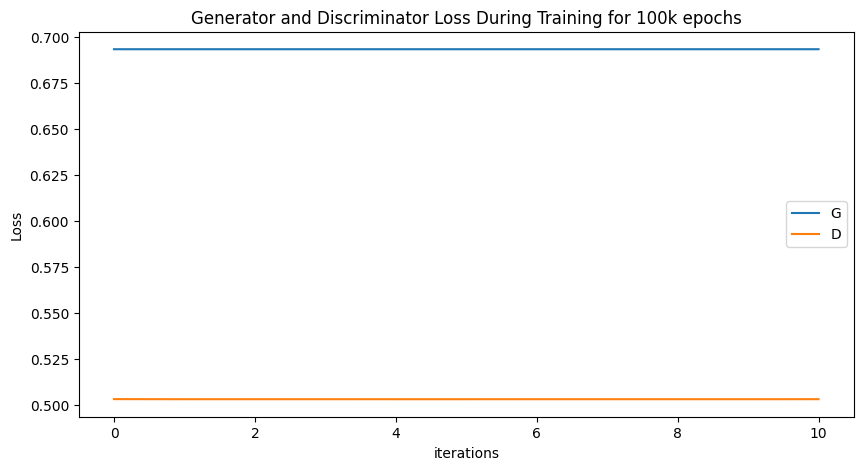

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training for 100k epochs")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

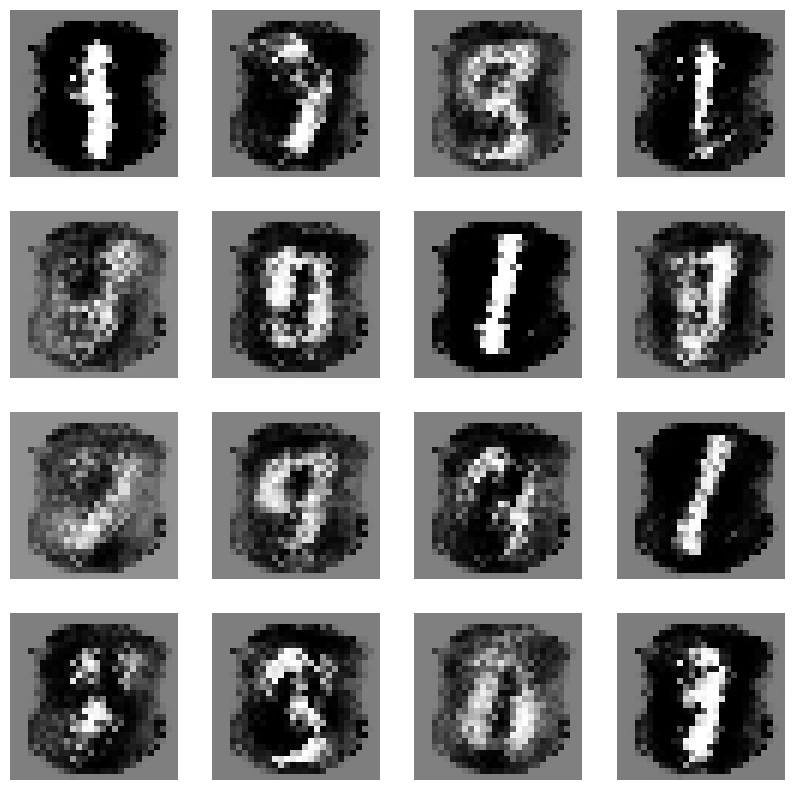

In [ ]:
# Generate images with the trained generator
z = torch.randn(16, latent_dim, device=device)
with torch.no_grad():
    gen_imgs = generator(z).cpu().view(-1, 28, 28)

# Plot these generated images
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(gen_imgs[i], cmap='gray')
    plt.axis('off')
plt.show()


# Task 2.3 CGAN

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_size):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, img_size),
            nn.Tanh()  # Using Tanh for normalized input images (-1, 1)
        )

    def forward(self, noise, labels):
        label_input = self.label_embedding(labels)
        gen_input = torch.cat((noise, label_input), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), 1, 28, 28)
        return img

class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(img_size + num_classes, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        label_input = self.label_embedding(labels)
        d_input = torch.cat((img_flat, label_input), -1)
        validity = self.model(d_input)
        return validity


In [ ]:
num_classes = 10
img_size = 28*28
# Initialize models
generator = Generator(latent_dim, num_classes, img_size).to(device)
discriminator = Discriminator(num_classes, img_size).to(device)

In [ ]:
def train_CGAN_model(generator, discriminator, criterion, optimizer_G, optimizer_D, train_loader, num_epochs, device):
    for epoch in range(num_epochs):
        for i, (imgs, labels) in enumerate(train_loader):
            imgs = imgs.to(device)
            labels = labels.to(device)
            # Adversarial ground truths
            valid = torch.ones(imgs.size(0), 1, device=imgs.device)
            fake = torch.zeros(imgs.size(0), 1, device=imgs.device)

            # Configure input
            real_imgs = imgs.to(imgs.device)

            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()

            # Sample noise as generator input
            z = torch.randn(imgs.size(0), latent_dim, device=imgs.device)

            # Generate a batch of images
            gen_imgs = generator(z, labels)

            # Loss measures generator's ability to fool the discriminator
            adversarial_loss = criterion
            g_loss = adversarial_loss(discriminator(gen_imgs, labels), valid)

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), labels), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        if epoch % 200 == 0:
            print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}]")
    return G_losses, D_losses



In [ ]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss()
G_losses = []
D_losses = []
epochs = 2000
G_losses, D_losses = train_CGAN_model(generator, discriminator, criterion, optimizer_G, optimizer_D, train_loader, epochs, device)

[Epoch 0/2000] [D loss: 0.504668] [G loss: 0.693147]
[Epoch 200/2000] [D loss: 0.813264] [G loss: 0.313262]
[Epoch 400/2000] [D loss: 0.813302] [G loss: 0.313262]
[Epoch 600/2000] [D loss: 0.504882] [G loss: 0.690300]
[Epoch 800/2000] [D loss: 0.503276] [G loss: 0.693147]
[Epoch 1000/2000] [D loss: 0.503297] [G loss: 0.693076]
[Epoch 1200/2000] [D loss: 0.813278] [G loss: 0.313262]
[Epoch 1400/2000] [D loss: 0.503890] [G loss: 0.692720]
[Epoch 1600/2000] [D loss: 0.531780] [G loss: 0.656221]
[Epoch 1800/2000] [D loss: 0.503217] [G loss: 0.693147]


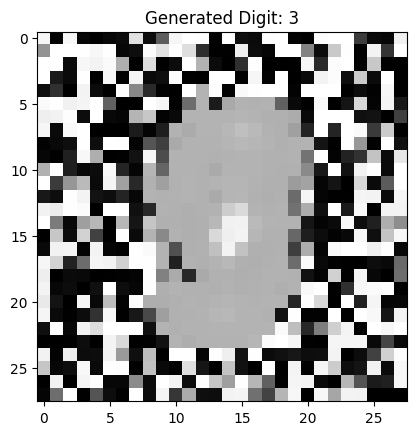

In [ ]:
# Generate images for a specific label (e.g., digit 3)
label = 3  # Choose from 0-9
label_tensor = torch.LongTensor([label]).to(device)
noise = torch.randn(1, latent_dim).to(device)

with torch.no_grad():
    generated_image = generator(noise, label_tensor)

plt.imshow(generated_image.cpu().detach().numpy().reshape(28, 28), cmap='gray')
plt.title(f"Generated Digit: {label}")
plt.show()


# 2.4 CNN

In [ ]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)  # preserves dimension
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)  # preserves dimension

        # Fully connected layers
        self.fc1 = nn.Linear(7*7*64, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        # Reshape input to 28 x 28 x 1
        x = x.view(-1, 1, 28, 28)

        # Convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten the output for the dense layers
        x = x.view(-1, 7*7*64)

        # Dense layers with dropout
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)  # Apply dropout only during training
        x = self.fc2(x)

        return x


In [ ]:
def train_cnn_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, transform=False):
    best_vloss = 10
    train_loss_lst = []
    vali_loss_lst = []
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0

        for (inputs, labels) in train_loader:
            # print("train label", labels)
            # inputs_aug = transform(inputs)
            inputs_aug = inputs.to(device)
            labels = labels.to(device)
#             if transform:
#                 inputs_aug = transform_mnist(inputs).to(device)
#             else:
#                 inputs_aug = transform_tensor(inputs).to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs_aug)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item()

        # Calculate average training loss for this epoch
        avg_train_loss = train_loss / (len(train_loader))

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for (inputs, labels) in val_loader:

#                 if transform:
#                     inputs = transform_mnist(inputs).to(device)
#                 else:
#                     inputs = transform_tensor(inputs).to(device)
#                     inputs = transform_tensor(inputs).to(device)
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Calculate average validation loss for this epoch
        avg_vloss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_vloss:.4f}")

        if avg_vloss < best_vloss:
            # print("loss is small")
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)

        train_loss_lst.append(avg_train_loss)
        vali_loss_lst.append(avg_vloss)

    print("Training complete!")
    return model_path, train_loss_lst, vali_loss_lst

In [ ]:
model = MNISTCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-5)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
trained_model = train_cnn_model(model, criterion, optimizer, train_loader, vali_loader, 10, False)

Epoch [1/10] - Train Loss: 0.2650 - Val Loss: 0.0687
Epoch [2/10] - Train Loss: 0.0667 - Val Loss: 0.0338
Epoch [3/10] - Train Loss: 0.0457 - Val Loss: 0.0309
Epoch [4/10] - Train Loss: 0.0333 - Val Loss: 0.0199
Epoch [5/10] - Train Loss: 0.0313 - Val Loss: 0.0154
Epoch [6/10] - Train Loss: 0.0228 - Val Loss: 0.0146
Epoch [7/10] - Train Loss: 0.0197 - Val Loss: 0.0109
Epoch [8/10] - Train Loss: 0.0173 - Val Loss: 0.0139
Epoch [9/10] - Train Loss: 0.0145 - Val Loss: 0.0088
Epoch [10/10] - Train Loss: 0.0125 - Val Loss: 0.0085
Training complete!


In [ ]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('Accuracy: %.2f %%' % accuracy)


Accuracy: 99.19 %


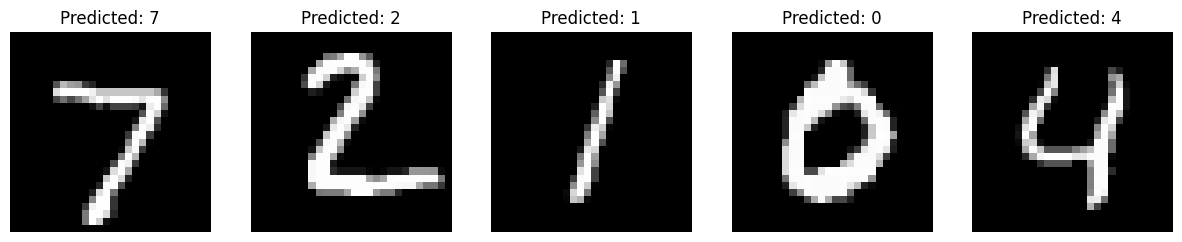

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get predictions
output = model(images)
_, preds = torch.max(output, 1)

# Convert image for display
images = images.cpu().numpy()
preds = preds.cpu().numpy()

# Plot
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(np.squeeze(images[i]), cmap='gray')
    ax[i].set_title(f'Predicted: {preds[i]}')
    ax[i].axis('off')
plt.show()


In [ ]:
def create_plot_adversarial_images(model, original_image, target_label, lr=0.1, n_steps=1, output_probs=False):
    model.eval()  # Set model to evaluation mode
    original_image = original_image.to(device)  # Ensure tensor is on the correct device
    target_label = target_label.to(device)
    image_adv = original_image.clone().detach().requires_grad_(True)

    probs_per_step = []
    fig, ax = plt.subplots(n_steps, 2)
    for _ in range(n_steps):

        output = model(image_adv)
        loss = torch.nn.functional.cross_entropy(output, target_label)
        model.zero_grad()
        loss.backward()
        data_grad = image_adv.grad.data

        # Create adversarial image by adjusting the original image
        image_adv = image_adv - lr * data_grad.sign() / n_steps
        image_adv = torch.clamp(image_adv, 0, 1).detach_().requires_grad_(True)  # Clamp to ensure it's still an image

        if output_probs:
            # Optionally output probabilities
            output = model(image_adv)
            probs = torch.nn.functional.softmax(output, dim=1).detach().cpu().numpy()
            probs_per_step.append(probs)

        adversarial_image = image_adv.squeeze().detach().cpu().numpy()
        ax[_,0].imshow(original_image.detach().cpu().numpy().reshape(28,28,1), cmap='gray')
        ax[_,0].set_title(f"Adversarial Image with Target Label: {target_label.item()}")
        ax[_,1].imshow(adversarial_image, cmap='gray')
        ax[_,1].set_title(f"Adversarial Image Label: {target_label.item()}")
    plt.show()
    return image_adv, probs_per_step


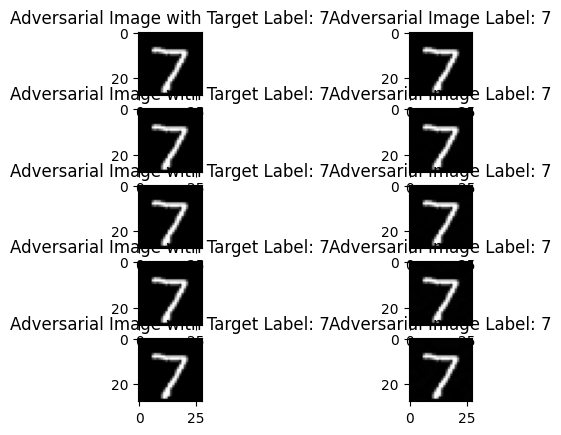

In [ ]:
# Assuming you have a DataLoader for MNIST
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Select a single image and label
image, label = images[0:1], labels[0:1]  # Ensure they are unsqueezed so the batch dimension is present

# Generate adversarial image
adversarial_image, probs_steps = create_plot_adversarial_images(model, image, label, lr=0.01, n_steps=5, output_probs=True)

# # Convert tensor image for visualization
# adversarial_image = adversarial_image.squeeze().detach().cpu().numpy()
# plt.imshow(adversarial_image, cmap='gray')
# plt.title(f"Adversarial Image with Target Label: {label.item()}")
# plt.show()

# Optionally, print probabilities
output_probs=False
if output_probs:
    print("Probabilities per step:", probs_steps)


In [ ]:
# Pick a random 2 image from first 1000 images
# Create adversarial image and with target label 6
index_of_2s = np.nonzero(mnist.test.labels[0:1000][:,2])[0]
rand_index = np.random.randint(0, len(index_of_2s))
image_norm = mnist.test.images[index_of_2s[rand_index]]
image_norm = np.reshape(image_norm, (1, 784))
label_adv = [0,0,0,0,0,0,1,0,0,0] # one hot encoded, adversarial label 6

NameError: name 'mnist' is not defined

In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
import numpy as np

def plot_predictions(model, image_list, output_probs=False, adversarial=False):
    # Ensure model is in evaluation mode
    model.eval()
    image_tensor = torch.tensor(image_list).float().to(device)  # Convert image list to PyTorch tensor
    outputs = model(image_tensor)
    prob = torch.nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()

    pred_list = np.argmax(prob, axis=1)
    pct_list = np.max(prob, axis=1) * 100

    # Setup image grid
    cols = 3
    rows = (len(image_list) + cols - 1) // cols
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.5)

    for i, ax in enumerate(grid):
        image = image_list[i].reshape(28, 28)
        ax.imshow(image, cmap='gray')
        title = f"Label: {pred_list[i]} \nCertainty: {pct_list[i]:.2f}%"
        if adversarial and i % 3 == 1:
            title = "Adversarial \nPartial Derivatives"
        ax.set_title(title)
        ax.axis('off')

    plt.show()
    return prob if output_probs else None

def plot_predictions(model, image_list, output_probs=False, adversarial=False):
    model.eval()
    image_tensor = torch.tensor(image_list).float().to(device)  # Make sure to send the tensors to the device
    outputs = model(image_tensor)
    prob = torch.nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()

    pred_list = np.argmax(prob, axis=1)
    pct_list = np.max(prob, axis=1) * 100

    # Setup image grid
    cols = 3
    rows = (len(image_list) + cols - 1) // cols  # Calculate rows needed
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.5)

    for i, ax in enumerate(grid):
        if i < len(image_list):  # Check if the current index is less than the length of the image list
            image = image_list[i].reshape(28, 28)
            ax.imshow(image, cmap='gray')
            title = 'Label: {} \nCertainty: {:.2f}%'.format(pred_list[i], pct_list[i])
            if adversarial and i % 3 == 1:
                title = "Adversarial \nPartial Derivatives"
            ax.set_title(title)
            ax.axis('off')
        else:
            ax.axis('off')  # Turn off axis for unused subplots

    plt.show()
    return prob if output_probs else None
def create_plot_adversarial_images(model, original_image, target_label, device, lr=0.1, n_steps=1, output_probs=False):
    model.eval()
    original_image = original_image.to(device)
    target_label = torch.tensor([target_label], device=device)

    # Create a copy of the original image to modify
    image_adv = original_image.clone().detach().requires_grad_(True)

    probs_per_step = []

    for _ in range(n_steps):
        output = model(image_adv)
        loss = torch.nn.functional.cross_entropy(output, target_label)
        model.zero_grad()
        loss.backward()

        # Create adversarial image by adjusting the original image
        with torch.no_grad():
            image_adv = image_adv - lr * image_adv.grad.sign() / n_steps
            image_adv = torch.clamp(image_adv, 0, 1)

        image_adv.requires_grad_(True)

        # For visualization and plotting
        adv_image_np = image_adv.detach().cpu().numpy().reshape(1, -1)
        img_adv_list = np.vstack([original_image.cpu().numpy().reshape(1, -1), adv_image_np])
        probs = plot_predictions(model, img_adv_list, output_probs=output_probs, adversarial=True)
        probs_per_step.append(probs) if output_probs else None

    return probs_per_step


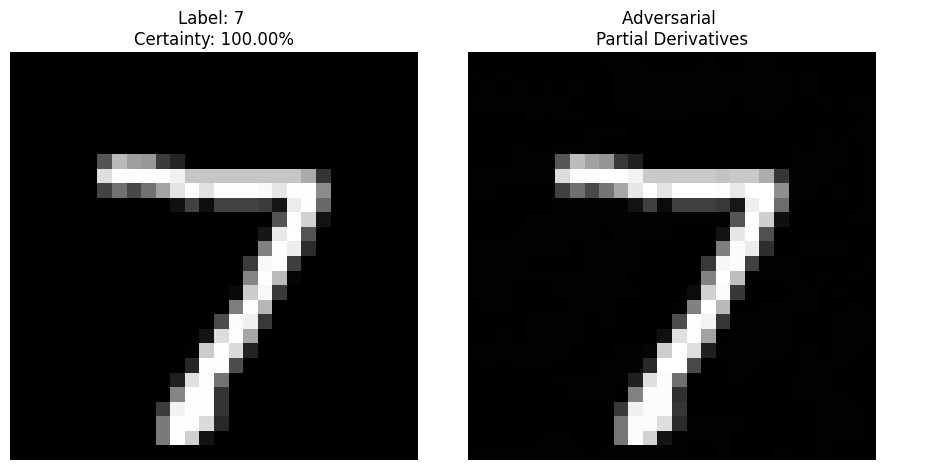

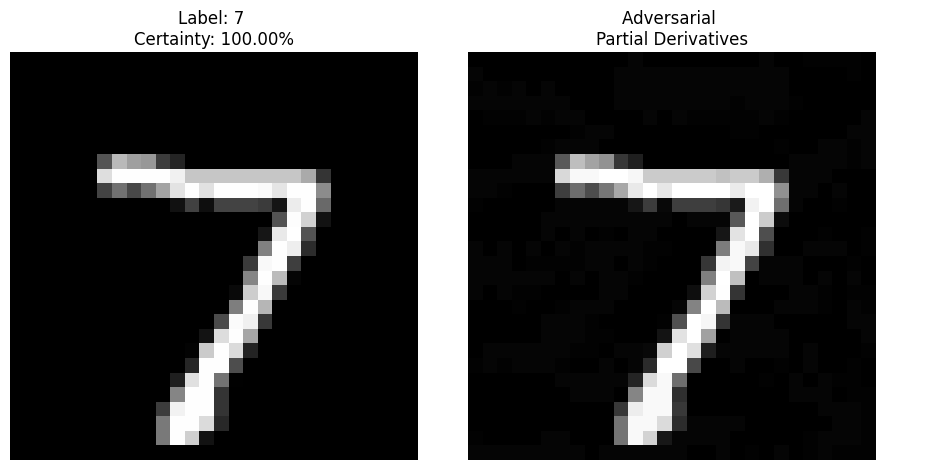

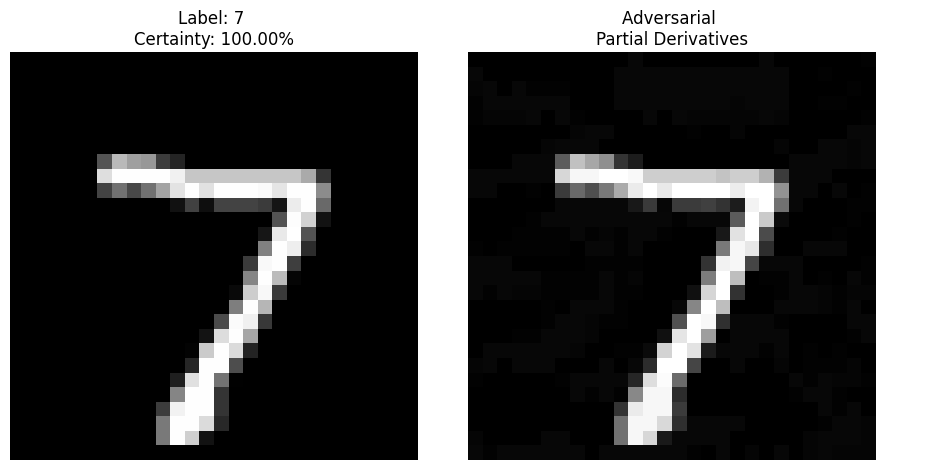

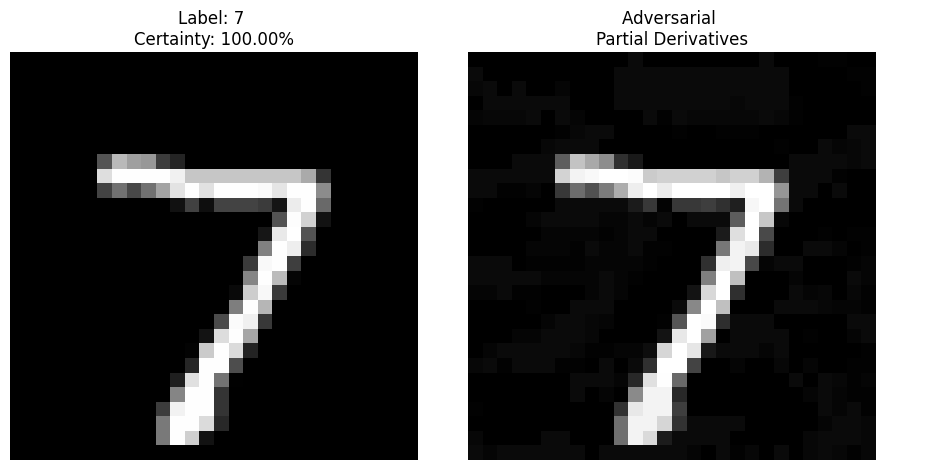

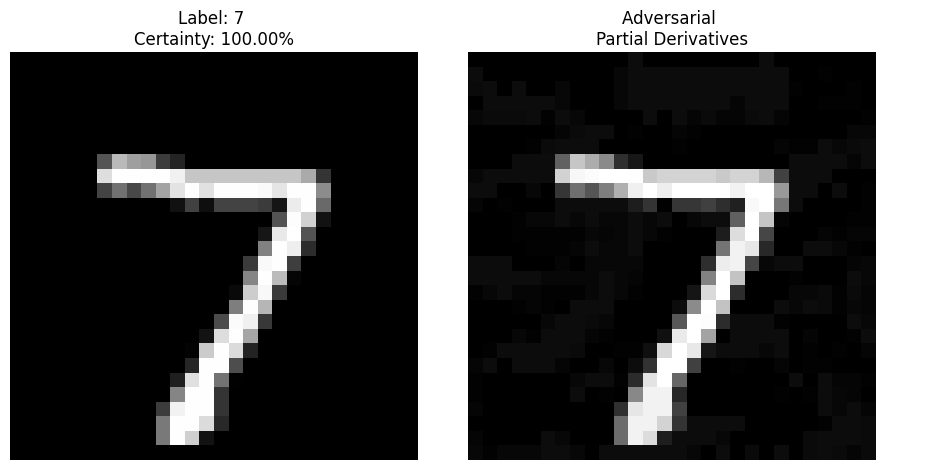

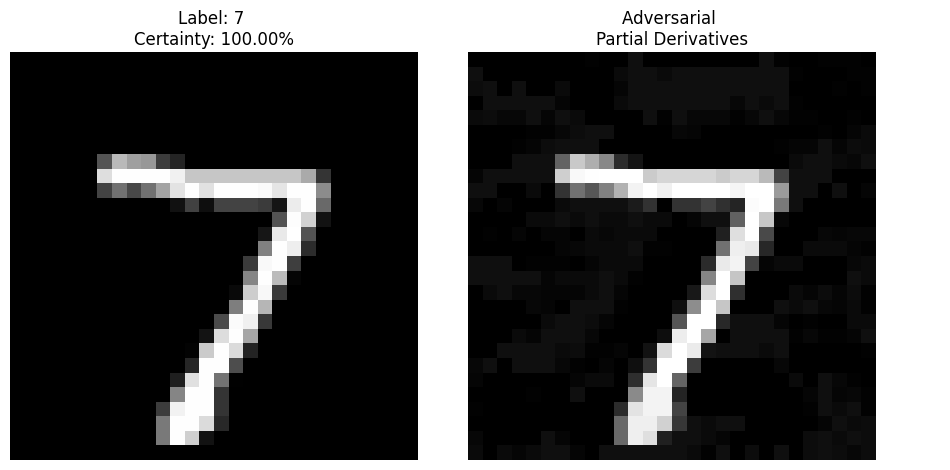

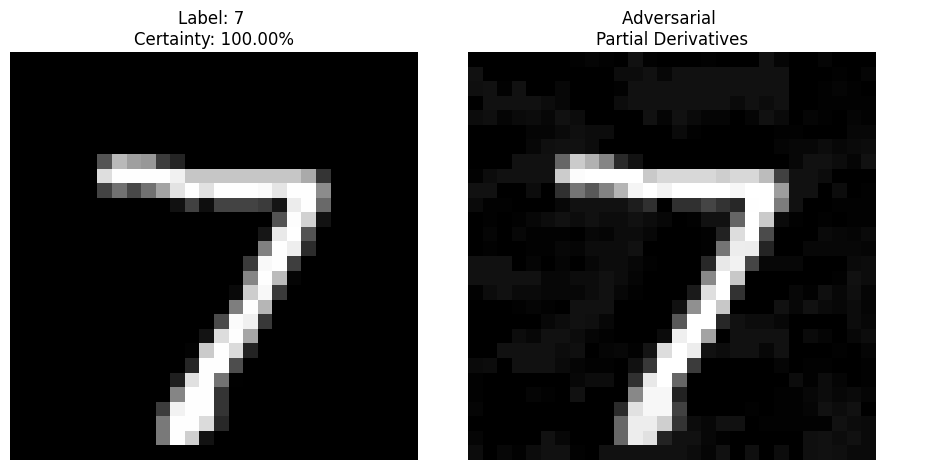

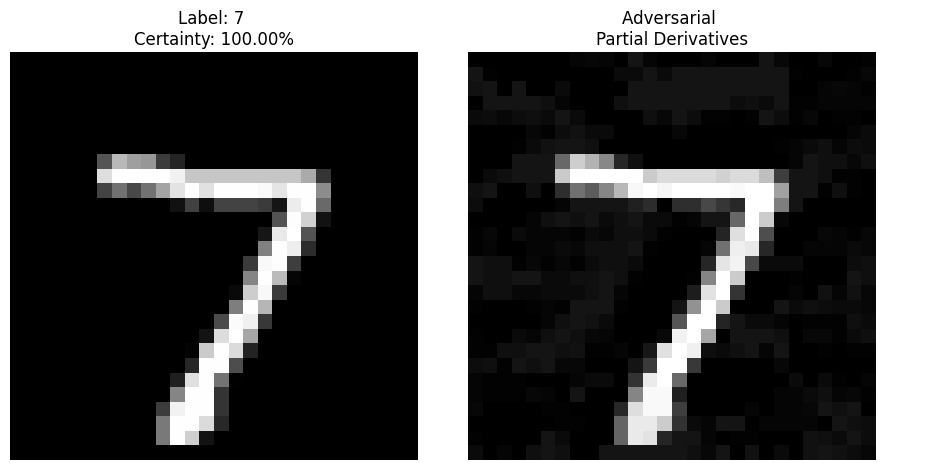

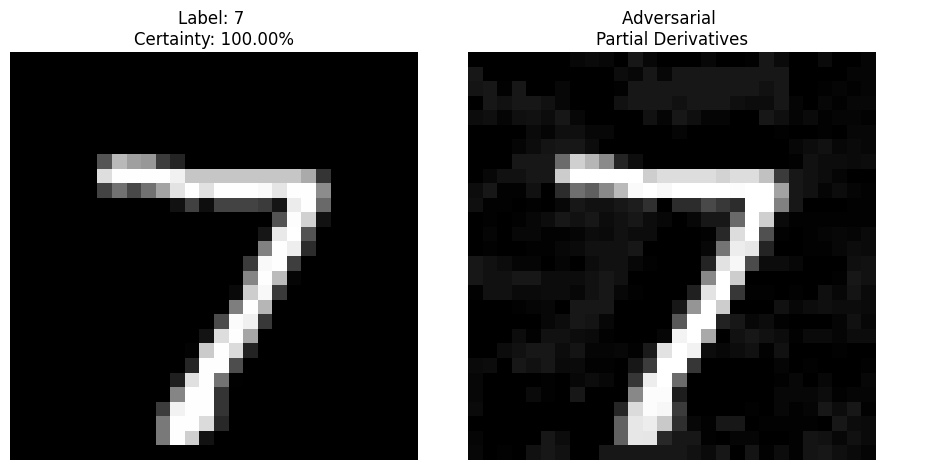

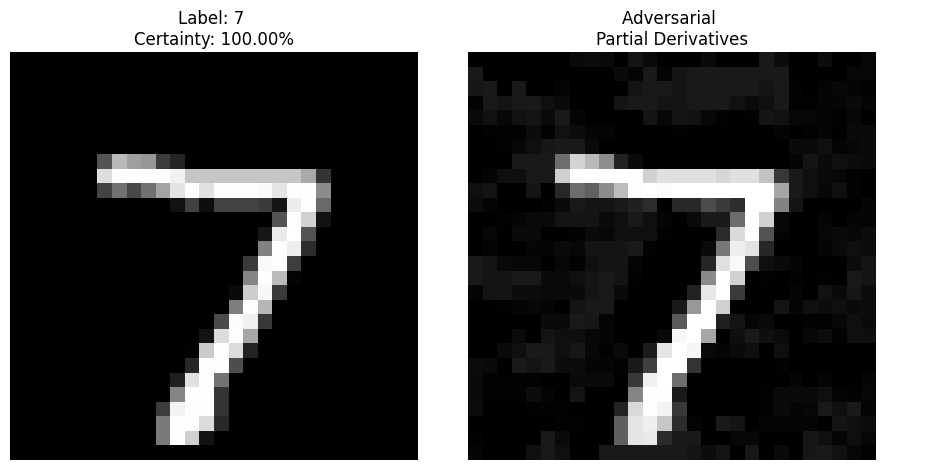

[array([[7.2747190e-12, 1.9720045e-11, 3.7256490e-11, 2.5664195e-09,
         3.2778488e-11, 8.7947621e-11, 8.7366403e-16, 1.0000000e+00,
         2.8901836e-10, 8.9748153e-10],
        [7.2030884e-12, 2.0009895e-11, 3.8201883e-11, 1.4388348e-09,
         2.8271484e-11, 8.2631589e-11, 8.8187771e-16, 1.0000000e+00,
         2.3171377e-10, 5.6165961e-10]], dtype=float32),
 array([[7.2747190e-12, 1.9720045e-11, 3.7256490e-11, 2.5664195e-09,
         3.2778488e-11, 8.7947621e-11, 8.7366403e-16, 1.0000000e+00,
         2.8901836e-10, 8.9748153e-10],
        [7.0216558e-12, 2.1106745e-11, 4.0373017e-11, 8.6059931e-10,
         2.5777150e-11, 7.8904036e-11, 9.0311108e-16, 1.0000000e+00,
         1.8323532e-10, 3.5456754e-10]], dtype=float32),
 array([[7.2747190e-12, 1.9720045e-11, 3.7256490e-11, 2.5664195e-09,
         3.2778488e-11, 8.7947621e-11, 8.7366403e-16, 1.0000000e+00,
         2.8901836e-10, 8.9748153e-10],
        [6.2784283e-12, 2.1445999e-11, 4.0637313e-11, 4.7099419e-10,
       

In [ ]:
# Example call to create_plot_adversarial_images
original_image = torch.randn(1, 784).to(device)  # This should be a real image from MNIST
# Assuming you have a DataLoader for MNIST
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Select a single image and label
image, label = images[0:1], labels[0:1]  # Ensure they are unsqueezed so the batch dimension is present
original_image = image
target_label = label

create_plot_adversarial_images(model, original_image, target_label, device, lr=0.1, n_steps=10, output_probs=True)
